In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt;
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import os as os
import cv2

In [2]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# Preparing The Data

In [3]:
data = np.load('data_train220.npy')
n=220

In [4]:
labels = np.load('labels_train.npy')

In [5]:
len(data)

8443

In [6]:
labels = to_categorical(labels,num_classes=9)

In [7]:
# Assuming you have data and labels as numpy arrays
# Shuffle indices
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

# Shuffle data and labels using the shuffled indices
data = data[indices]
labels = labels[indices]

In [8]:
data.shape

(8443, 220, 220, 3)

In [9]:
mycutdata=data[7754:-1,:,:,:]
mycutlabels=labels[7754:-1]


In [10]:
data=data[0:7753,:,:,:]

In [11]:
labels=labels[0:7753]

In [12]:
mycutdata = tf.data.Dataset.from_tensor_slices((mycutdata, mycutlabels))


2023-12-06 04:25:49.466917: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 04:25:50.736957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-12-06 04:25:50.742248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


In [13]:

buffer_size = len(data)  # Set buffer size as per your dataset size
data = tf.data.Dataset.from_tensor_slices((data, labels))
data = data.shuffle(buffer_size)

# Training The Model


In [20]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
 
#lr_scheduler = ReduceLROnPlateau(
#    monitor='val_loss',  # You can also use 'val_accuracy' or other metrics
#    factor=0.2,           # Factor by which the learning rate will be reduced
#    patience=6,          # Number of epochs with no improvement after which learning rate will be reduced
#    min_lr=1e-6           # Lower bound on the learning rate
#)

# Create the Xception base model
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(n, n, 3),
    pooling='avg'
)
base_model.trainable = False
x = Flatten()(base_model.output)
base_model.trainable = True
# Fine-tune only the last few layers
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

#base_model.trainable = True

# Fine-tune only the last few layers

x = Dense(300, activation='relu')(x)#, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x=Dropout(0.60)(x)
#x = Dense(100, activation='relu')(x)#, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
#x=Dropout(0.52)(x)
x = Dense(27, activation='relu')(x)
x=Dropout(0.5)(x)
outputs = Dense(9, activation='softmax')(x)

# Create the full model
xception_model = Model(inputs=base_model.input, outputs=outputs)

In [21]:
xception_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 109, 109, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 109, 109, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [22]:
from tensorflow.keras.optimizers import Nadam
optimizer = Nadam(learning_rate=0.0001, beta_1=0.96, beta_2=0.998)
xception_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Define a checkpoint callback
checkpoint_path = 'best_weights7.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',  # Monitor validation loss
                             save_best_only=True,  # Save only the best model
                             mode='min',  # Save when validation loss improves
                             verbose=1)  # Show messages about the saving process
epochs=50
batch_size = 73
# Train the model with the callback
history = xception_model.fit(data.batch(batch_size),
                             epochs=epochs,
                             validation_data=mycutdata.batch(batch_size),
                             callbacks=[cp_callback])


Epoch 1/50
107/107 [==============================] - ETA: 0s - loss: 2.0402 - accuracy: 0.2141
Epoch 00001: val_loss improved from inf to 1.33564, saving model to best_weights7.h5
107/107 [==============================] - 13s 85ms/step - loss: 2.0402 - accuracy: 0.2141 - val_loss: 1.3356 - val_accuracy: 0.5843
Epoch 2/50
106/107 [============================>.] - ETA: 0s - loss: 1.1428 - accuracy: 0.5956
Epoch 00002: val_loss improved from 1.33564 to 0.45047, saving model to best_weights7.h5
107/107 [==============================] - 8s 76ms/step - loss: 1.1417 - accuracy: 0.5962 - val_loss: 0.4505 - val_accuracy: 0.8823
Epoch 3/50
106/107 [============================>.] - ETA: 0s - loss: 0.6683 - accuracy: 0.7643
Epoch 00003: val_loss improved from 0.45047 to 0.24926, saving model to best_weights7.h5
107/107 [==============================] - 8s 77ms/step - loss: 0.6696 - accuracy: 0.7636 - val_loss: 0.2493 - val_accuracy: 0.9404
Epoch 4/50
106/107 [============================>.] 

# cheking the effect of threshold

In [24]:
threshold = 0.8  # Define your threshold value

# Evaluate the model while applying the threshold
total_samples = 0
correct_samples = 0

for batch in mycutdata.batch(batch_size):
    images, labels = batch
    predictions = xception_model.predict(images)

    for i in range(len(predictions)):
        predicted_class = np.argmax(predictions[i])
        max_probability = np.max(predictions[i])

        if max_probability >= threshold:
            total_samples += 1
            if predicted_class == np.argmax(labels[i]):
                correct_samples += 1
        else:
            # If prediction is uncertain, mark it as mislabeled
            total_samples += 1

accuracy_with_threshold = correct_samples / total_samples if total_samples > 0 else 0

print(f"Accuracy with threshold {threshold}: {accuracy_with_threshold}")

Accuracy with threshold 0.8: 0.9680232558139535


# Evaluating The Model

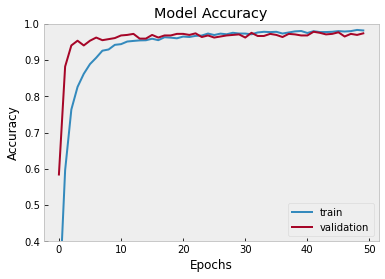

In [25]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

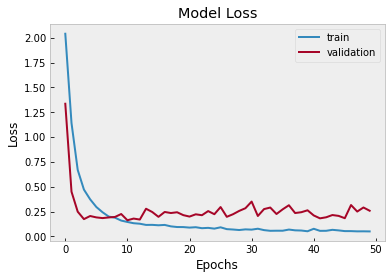

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()